In [48]:
import pandas as pd

# Read the CSV file into a DataFrame
column_names = ["text", "is_hate"]

df = pd.read_csv('1.preprocessed_data.csv', on_bad_lines='skip', sep=",", encoding='iso-8859-1', header=0, names=column_names)
df['is_hate'] = df['is_hate'].astype(bool)
df['text'] = df['text'].astype('str')
df.head()

,text,is_hate
0,ponnayo danne kellek aduwa gaman laga inna kol...,True
1,ape harak samjeta eka honda adrshyak,False
2,tpita pisuda yako man htuwe atta kiyala aiyo,False
3,kimbak eduwoth ape untath amma thaththawath pe...,True
4,lisan nathawa yanna puluwan yako api dannawa o...,False


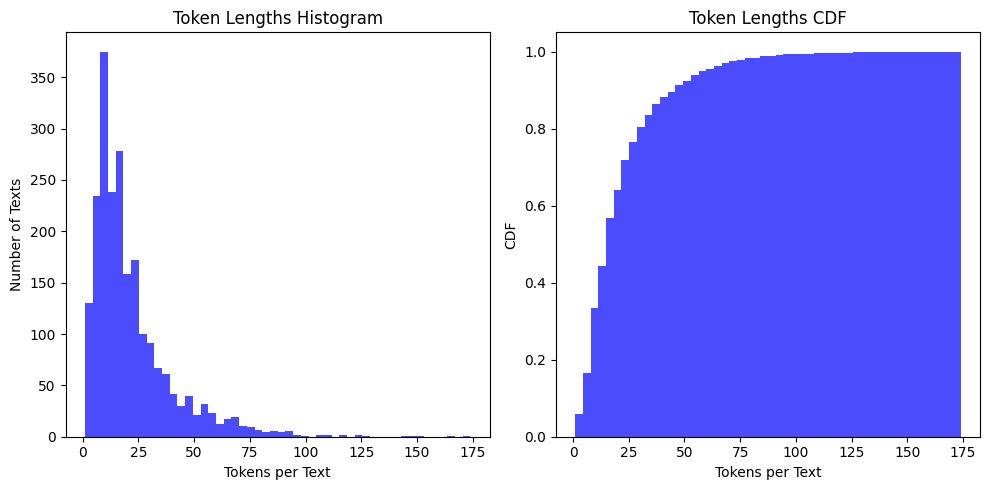

To cover 100% of the data, set max_length to 174.


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import BertTokenizer

# Assume df already exists
# df = pd.read_csv('your_file.csv')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Calculate token lengths
token_lengths = df['text'].apply(lambda x: len(tokenizer.tokenize(x)))

# Plot histogram
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(token_lengths, bins=50, facecolor='blue', alpha=0.7)
plt.title('Token Lengths Histogram')
plt.xlabel('Tokens per Text')
plt.ylabel('Number of Texts')

# Plot CDF
plt.subplot(1, 2, 2)
plt.hist(token_lengths, bins=50, facecolor='blue', alpha=0.7, cumulative=True, density=True)
plt.title('Token Lengths CDF')
plt.xlabel('Tokens per Text')
plt.ylabel('CDF')

plt.tight_layout()
plt.show()

# Determine optimal max_length based on desired coverage
desired_coverage = 1
optimal_max_length = int(token_lengths.quantile(desired_coverage))
print(f"To cover {desired_coverage*100}% of the data, set max_length to {optimal_max_length}.")


In [24]:
import pandas as pd
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, random_split
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig, AdamW, get_linear_schedule_with_warmup
import optuna
from tqdm import tqdm

# Assuming the dataset is loaded into a DataFrame named df
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_length = 256

def tokenize_data(texts, tokenizer, max_length):
    return tokenizer(texts, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')

def objective(trial):
    tokens = tokenize_data(df['text'].tolist(), tokenizer, max_length)
    dataset = TensorDataset(tokens.input_ids, tokens.attention_mask, torch.tensor(df['is_hate'].values).long())

    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Suggest hyperparameters
    lr = trial.suggest_float('lr', 1e-6, 1e-4, log=True)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])
    epochs = trial.suggest_int('epochs', 1, 5)
    dropout_rate = trial.suggest_float('dropout', 0.1, 0.5, step=0.1)
    warmup = trial.suggest_float('warmup', 0.0, 0.3)

    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Modify config for dropout
    config = BertConfig.from_pretrained('bert-base-uncased', hidden_dropout_prob=dropout_rate, attention_probs_dropout_prob=dropout_rate)
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)
    
    optimizer = AdamW(model.parameters(), lr=lr)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(warmup * total_steps), num_training_steps=total_steps)

    # Training loop
    for epoch in range(epochs):
        model.train()
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}", leave=False):
            input_ids, attention_mask, labels = batch
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()

    # Validation
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    for batch in tqdm(val_loader, desc="Validation", leave=False):
        input_ids, attention_mask, labels = batch
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        total_eval_loss += outputs.loss.item()
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        total_eval_accuracy += (predictions == labels).sum().item()

    avg_val_accuracy = total_eval_accuracy / len(val_loader.dataset)
    print(f"Validation Accuracy: {avg_val_accuracy:.4f}")

    # Return the negative of the accuracy for optuna to minimize
    return avg_val_accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print(f"Value: {trial.value:.4f}")
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2023-10-08 10:15:20,512] A new study created in memory with name: no-name-520130e4-ca22-4018-b47d-b84099a8145c
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/meuru/projects/MSc/Final Project/venv/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
[I 2023-10-08 10:30:13,734] Trial 0 finished with value: 0.5429864253393665 and parameters: {'lr': 3.24808382876764e-05, 'batch_size': 16, 'epochs': 2, 'dropout': 0.5, 'warmup': 0.29891744041525564}. Best is trial 0 with value: 0.5429864253393665.


Validation Accuracy: 0.5430


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-08 11:03:34,675] Trial 1 finished with value: 0.416289592760181 and parameters: {'lr': 1.90633295552527e-06, 'batch_size': 32, 'epochs': 4, 'dropout': 0.5, 'warmup': 0.041174607888578095}. Best is trial 0 with value: 0.5429864253393665.


Validation Accuracy: 0.4163


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-08 11:31:49,070] Trial 2 finished with value: 0.583710407239819 and parameters: {'lr': 1.1323746084808275e-06, 'batch_size': 16, 'epochs': 4, 'dropout': 0.30000000000000004, 'warmup': 0.21091660024988165}. Best is trial 2 with value: 0.583710407239819.


Validation Accuracy: 0.5837


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-08 11:59:17,452] Trial 3 finished with value: 0.6063348416289592 and parameters: {'lr': 3.630085239415778e-05, 'batch_size': 8, 'epochs': 4, 'dropout': 0.4, 'warmup': 0.033354658212404596}. Best is trial 3 with value: 0.6063348416289592.


Validation Accuracy: 0.6063


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-08 12:33:15,145] Trial 4 finished with value: 0.5429864253393665 and parameters: {'lr': 1.1005032968994502e-05, 'batch_size': 8, 'epochs': 5, 'dropout': 0.5, 'warmup': 0.27177887995725053}. Best is trial 3 with value: 0.6063348416289592.


Validation Accuracy: 0.5430


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-08 13:07:46,473] Trial 5 finished with value: 0.5746606334841629 and parameters: {'lr': 3.032341991353525e-05, 'batch_size': 16, 'epochs': 5, 'dropout': 0.5, 'warmup': 0.12082692668340339}. Best is trial 3 with value: 0.6063348416289592.


Validation Accuracy: 0.5747


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-08 13:34:27,328] Trial 6 finished with value: 0.7104072398190046 and parameters: {'lr': 2.0285110143801845e-05, 'batch_size': 8, 'epochs': 4, 'dropout': 0.30000000000000004, 'warmup': 0.28359990941348395}. Best is trial 6 with value: 0.7104072398190046.


Validation Accuracy: 0.7104


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-08 13:42:43,925] Trial 7 finished with value: 0.5701357466063348 and parameters: {'lr': 1.6308321160172352e-06, 'batch_size': 32, 'epochs': 1, 'dropout': 0.1, 'warmup': 0.20070889440066933}. Best is trial 6 with value: 0.7104072398190046.


Validation Accuracy: 0.5701


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-08 14:14:20,698] Trial 8 finished with value: 0.6108597285067874 and parameters: {'lr': 5.152501946479697e-06, 'batch_size': 32, 'epochs': 4, 'dropout': 0.30000000000000004, 'warmup': 0.163770547167883}. Best is trial 6 with value: 0.7104072398190046.


Validation Accuracy: 0.6109


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-08 14:34:28,323] Trial 9 finished with value: 0.6153846153846154 and parameters: {'lr': 7.261856807792169e-05, 'batch_size': 8, 'epochs': 3, 'dropout': 0.2, 'warmup': 0.04121072664799173}. Best is trial 6 with value: 0.7104072398190046.


Validation Accuracy: 0.6154


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-08 14:47:52,605] Trial 10 finished with value: 0.746606334841629 and parameters: {'lr': 1.1040167933487589e-05, 'batch_size': 8, 'epochs': 2, 'dropout': 0.2, 'warmup': 0.2548844133945991}. Best is trial 10 with value: 0.746606334841629.


Validation Accuracy: 0.7466


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-08 15:01:20,162] Trial 11 finished with value: 0.7420814479638009 and parameters: {'lr': 1.1928930807098992e-05, 'batch_size': 8, 'epochs': 2, 'dropout': 0.2, 'warmup': 0.2596209782013574}. Best is trial 10 with value: 0.746606334841629.


Validation Accuracy: 0.7421


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-08 15:14:48,901] Trial 12 finished with value: 0.7963800904977375 and parameters: {'lr': 8.003161219849458e-06, 'batch_size': 8, 'epochs': 2, 'dropout': 0.1, 'warmup': 0.24244342269655517}. Best is trial 12 with value: 0.7963800904977375.


Validation Accuracy: 0.7964


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-08 15:21:36,397] Trial 13 finished with value: 0.583710407239819 and parameters: {'lr': 3.95180966543489e-06, 'batch_size': 8, 'epochs': 1, 'dropout': 0.1, 'warmup': 0.23266391839524286}. Best is trial 12 with value: 0.7963800904977375.


Validation Accuracy: 0.5837


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-08 15:35:10,534] Trial 14 finished with value: 0.665158371040724 and parameters: {'lr': 6.2411121341421495e-06, 'batch_size': 8, 'epochs': 2, 'dropout': 0.2, 'warmup': 0.24246343335981224}. Best is trial 12 with value: 0.7963800904977375.


Validation Accuracy: 0.6652


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-08 15:55:41,187] Trial 15 finished with value: 0.7692307692307693 and parameters: {'lr': 8.187009797707516e-06, 'batch_size': 8, 'epochs': 3, 'dropout': 0.1, 'warmup': 0.1922832132370134}. Best is trial 12 with value: 0.7963800904977375.


Validation Accuracy: 0.7692


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-08 16:15:34,524] Trial 16 finished with value: 0.6877828054298643 and parameters: {'lr': 3.1132698590833687e-06, 'batch_size': 8, 'epochs': 3, 'dropout': 0.1, 'warmup': 0.17337596679327905}. Best is trial 12 with value: 0.7963800904977375.


Validation Accuracy: 0.6878


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-08 16:35:43,792] Trial 17 finished with value: 0.751131221719457 and parameters: {'lr': 7.014954385376184e-06, 'batch_size': 8, 'epochs': 3, 'dropout': 0.1, 'warmup': 0.12860280313837347}. Best is trial 12 with value: 0.7963800904977375.


Validation Accuracy: 0.7511


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-08 16:59:01,321] Trial 18 finished with value: 0.7420814479638009 and parameters: {'lr': 1.6067972831647413e-05, 'batch_size': 32, 'epochs': 3, 'dropout': 0.1, 'warmup': 0.211772004750853}. Best is trial 12 with value: 0.7963800904977375.


Validation Accuracy: 0.7421


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-08 17:06:00,484] Trial 19 finished with value: 0.5882352941176471 and parameters: {'lr': 7.11707389783418e-06, 'batch_size': 16, 'epochs': 1, 'dropout': 0.4, 'warmup': 0.18332022775107526}. Best is trial 12 with value: 0.7963800904977375.


Validation Accuracy: 0.5882


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-08 17:19:20,872] Trial 20 finished with value: 0.6244343891402715 and parameters: {'lr': 3.4294726485729147e-06, 'batch_size': 8, 'epochs': 2, 'dropout': 0.2, 'warmup': 0.2294827945349233}. Best is trial 12 with value: 0.7963800904977375.


Validation Accuracy: 0.6244


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-08 17:39:14,336] Trial 21 finished with value: 0.7285067873303167 and parameters: {'lr': 7.543859851824896e-06, 'batch_size': 8, 'epochs': 3, 'dropout': 0.1, 'warmup': 0.13909905027329036}. Best is trial 12 with value: 0.7963800904977375.


Validation Accuracy: 0.7285


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-08 17:59:06,803] Trial 22 finished with value: 0.7782805429864253 and parameters: {'lr': 7.786388040913442e-06, 'batch_size': 8, 'epochs': 3, 'dropout': 0.1, 'warmup': 0.11677959828444888}. Best is trial 12 with value: 0.7963800904977375.


Validation Accuracy: 0.7783


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-08 18:12:29,825] Trial 23 finished with value: 0.6787330316742082 and parameters: {'lr': 4.851803736703564e-06, 'batch_size': 8, 'epochs': 2, 'dropout': 0.1, 'warmup': 0.09679125611341813}. Best is trial 12 with value: 0.7963800904977375.


Validation Accuracy: 0.6787


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-08 18:32:22,850] Trial 24 finished with value: 0.7375565610859729 and parameters: {'lr': 8.822516409071905e-06, 'batch_size': 8, 'epochs': 3, 'dropout': 0.2, 'warmup': 0.18489033079792103}. Best is trial 12 with value: 0.7963800904977375.


Validation Accuracy: 0.7376


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-08 18:47:10,294] Trial 25 finished with value: 0.746606334841629 and parameters: {'lr': 1.3292514988359177e-05, 'batch_size': 8, 'epochs': 2, 'dropout': 0.1, 'warmup': 0.15370594584693195}. Best is trial 12 with value: 0.7963800904977375.


Validation Accuracy: 0.7466


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-08 19:08:23,198] Trial 26 finished with value: 0.751131221719457 and parameters: {'lr': 9.197713909658949e-06, 'batch_size': 8, 'epochs': 3, 'dropout': 0.2, 'warmup': 0.09450398144040634}. Best is trial 12 with value: 0.7963800904977375.


Validation Accuracy: 0.7511


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-08 19:16:30,382] Trial 27 finished with value: 0.6289592760180995 and parameters: {'lr': 5.529624088821033e-06, 'batch_size': 8, 'epochs': 1, 'dropout': 0.1, 'warmup': 0.19692983327372449}. Best is trial 12 with value: 0.7963800904977375.


Validation Accuracy: 0.6290


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-08 19:31:36,839] Trial 28 finished with value: 0.5610859728506787 and parameters: {'lr': 1.861078792593682e-05, 'batch_size': 16, 'epochs': 2, 'dropout': 0.4, 'warmup': 0.22768520768040368}. Best is trial 12 with value: 0.7963800904977375.


Validation Accuracy: 0.5611


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-08 19:56:05,766] Trial 29 finished with value: 0.5565610859728507 and parameters: {'lr': 2.980015184711838e-06, 'batch_size': 32, 'epochs': 3, 'dropout': 0.2, 'warmup': 0.2784803762085608}. Best is trial 12 with value: 0.7963800904977375.


Validation Accuracy: 0.5566


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-08 20:24:40,556] Trial 30 finished with value: 0.7375565610859729 and parameters: {'lr': 8.494080258926243e-06, 'batch_size': 16, 'epochs': 4, 'dropout': 0.1, 'warmup': 0.15405867767152054}. Best is trial 12 with value: 0.7963800904977375.


Validation Accuracy: 0.7376


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-08 20:46:01,805] Trial 31 finished with value: 0.7873303167420814 and parameters: {'lr': 6.472605362716492e-06, 'batch_size': 8, 'epochs': 3, 'dropout': 0.1, 'warmup': 0.1250207904268518}. Best is trial 12 with value: 0.7963800904977375.


Validation Accuracy: 0.7873


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-08 21:07:21,075] Trial 32 finished with value: 0.7873303167420814 and parameters: {'lr': 4.792266878896108e-06, 'batch_size': 8, 'epochs': 3, 'dropout': 0.1, 'warmup': 0.1664698893024729}. Best is trial 12 with value: 0.7963800904977375.


Validation Accuracy: 0.7873


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-08 21:35:12,706] Trial 33 finished with value: 0.7737556561085973 and parameters: {'lr': 4.8611711655058435e-06, 'batch_size': 8, 'epochs': 4, 'dropout': 0.1, 'warmup': 0.1103244291480391}. Best is trial 12 with value: 0.7963800904977375.


Validation Accuracy: 0.7738


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-08 22:03:11,976] Trial 34 finished with value: 0.6832579185520362 and parameters: {'lr': 3.6940915687542085e-06, 'batch_size': 8, 'epochs': 4, 'dropout': 0.2, 'warmup': 0.14375718828557615}. Best is trial 12 with value: 0.7963800904977375.


Validation Accuracy: 0.6833


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-08 22:24:30,106] Trial 35 finished with value: 0.6515837104072398 and parameters: {'lr': 2.3676995857269536e-06, 'batch_size': 8, 'epochs': 3, 'dropout': 0.1, 'warmup': 0.2952297745612585}. Best is trial 12 with value: 0.7963800904977375.


Validation Accuracy: 0.6516


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-08 22:39:18,133] Trial 36 finished with value: 0.7285067873303167 and parameters: {'lr': 6.04886987355458e-06, 'batch_size': 8, 'epochs': 2, 'dropout': 0.1, 'warmup': 0.08356555823688827}. Best is trial 12 with value: 0.7963800904977375.


Validation Accuracy: 0.7285


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-08 23:15:26,031] Trial 37 finished with value: 0.669683257918552 and parameters: {'lr': 4.246747269240016e-06, 'batch_size': 16, 'epochs': 5, 'dropout': 0.2, 'warmup': 0.16926878702005138}. Best is trial 12 with value: 0.7963800904977375.


Validation Accuracy: 0.6697


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-08 23:32:59,710] Trial 38 finished with value: 0.6063348416289592 and parameters: {'lr': 9.944371418091512e-06, 'batch_size': 32, 'epochs': 2, 'dropout': 0.4, 'warmup': 0.12102353318448716}. Best is trial 12 with value: 0.7963800904977375.


Validation Accuracy: 0.6063


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-09 00:00:43,539] Trial 39 finished with value: 0.6515837104072398 and parameters: {'lr': 5.9776290868584594e-06, 'batch_size': 8, 'epochs': 4, 'dropout': 0.30000000000000004, 'warmup': 0.13600261245313303}. Best is trial 12 with value: 0.7963800904977375.


Validation Accuracy: 0.6516


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-09 00:22:01,052] Trial 40 finished with value: 0.6425339366515838 and parameters: {'lr': 2.494860127305137e-06, 'batch_size': 8, 'epochs': 3, 'dropout': 0.1, 'warmup': 0.20725565292445794}. Best is trial 12 with value: 0.7963800904977375.


Validation Accuracy: 0.6425


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-09 00:50:06,841] Trial 41 finished with value: 0.7828054298642534 and parameters: {'lr': 4.7083445879217755e-06, 'batch_size': 8, 'epochs': 4, 'dropout': 0.1, 'warmup': 0.10989408005158534}. Best is trial 12 with value: 0.7963800904977375.


Validation Accuracy: 0.7828


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-09 01:17:53,451] Trial 42 finished with value: 0.7420814479638009 and parameters: {'lr': 4.270330828245394e-06, 'batch_size': 8, 'epochs': 4, 'dropout': 0.1, 'warmup': 0.07404971250030849}. Best is trial 12 with value: 0.7963800904977375.


Validation Accuracy: 0.7421


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-09 01:52:30,235] Trial 43 finished with value: 0.8144796380090498 and parameters: {'lr': 4.825718084617628e-06, 'batch_size': 8, 'epochs': 5, 'dropout': 0.1, 'warmup': 0.11387251464281245}. Best is trial 43 with value: 0.8144796380090498.


Validation Accuracy: 0.8145


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-09 02:26:55,160] Trial 44 finished with value: 0.7737556561085973 and parameters: {'lr': 4.98765503219745e-06, 'batch_size': 8, 'epochs': 5, 'dropout': 0.1, 'warmup': 0.14857375335456216}. Best is trial 43 with value: 0.8144796380090498.


Validation Accuracy: 0.7738


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-09 02:59:57,149] Trial 45 finished with value: 0.7918552036199095 and parameters: {'lr': 6.265456815440735e-06, 'batch_size': 8, 'epochs': 5, 'dropout': 0.2, 'warmup': 0.06349315594102069}. Best is trial 43 with value: 0.8144796380090498.


Validation Accuracy: 0.7919


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-09 03:39:18,870] Trial 46 finished with value: 0.6923076923076923 and parameters: {'lr': 6.519191551630188e-06, 'batch_size': 32, 'epochs': 5, 'dropout': 0.2, 'warmup': 0.05486473694410498}. Best is trial 43 with value: 0.8144796380090498.


Validation Accuracy: 0.6923


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-09 04:12:39,507] Trial 47 finished with value: 0.755656108597285 and parameters: {'lr': 1.2005537772141845e-05, 'batch_size': 8, 'epochs': 5, 'dropout': 0.2, 'warmup': 0.015022952182498356}. Best is trial 43 with value: 0.8144796380090498.


Validation Accuracy: 0.7557


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-09 04:46:08,157] Trial 48 finished with value: 0.6108597285067874 and parameters: {'lr': 3.692168769572455e-06, 'batch_size': 8, 'epochs': 5, 'dropout': 0.30000000000000004, 'warmup': 0.06283703258131193}. Best is trial 43 with value: 0.8144796380090498.


Validation Accuracy: 0.6109


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-09 05:19:25,760] Trial 49 finished with value: 0.746606334841629 and parameters: {'lr': 5.897657458029708e-06, 'batch_size': 8, 'epochs': 5, 'dropout': 0.2, 'warmup': 0.15791978770964218}. Best is trial 43 with value: 0.8144796380090498.


Validation Accuracy: 0.7466
Number of finished trials:  50
Best trial:
Value: 0.8145
Params: 
    lr: 4.825718084617628e-06
    batch_size: 8
    epochs: 5
    dropout: 0.1
    warmup: 0.11387251464281245


In [25]:
print(study.best_params)
print(study.best_params['batch_size'])

{'lr': 4.825718084617628e-06, 'batch_size': 8, 'epochs': 5, 'dropout': 0.1, 'warmup': 0.11387251464281245}
8


In [29]:
# print(study.trials)
df_trials = study.trials_dataframe()
print(df_trials.columns)
df_trials.rename(columns = {'value':'Accuracy', 'params_batch_size':'Batch Size',
                              'params_dropout':'Dropout Rate', 'params_epochs': 'Number of Epochs', 'params_lr': 'Learning Rate'}, inplace = True)
print(df_trials)



Index(['number', 'value', 'datetime_start', 'datetime_complete', 'duration',
       'params_batch_size', 'params_dropout', 'params_epochs', 'params_lr',
       'params_warmup', 'state'],
      dtype='object')
    number  Accuracy             datetime_start          datetime_complete  \
0        0  0.542986 2023-10-08 10:15:20.513708 2023-10-08 10:30:13.734073   
1        1  0.416290 2023-10-08 10:30:13.734855 2023-10-08 11:03:34.674760   
2        2  0.583710 2023-10-08 11:03:34.675614 2023-10-08 11:31:49.070520   
3        3  0.606335 2023-10-08 11:31:49.071342 2023-10-08 11:59:17.451713   
4        4  0.542986 2023-10-08 11:59:17.452539 2023-10-08 12:33:15.144803   
5        5  0.574661 2023-10-08 12:33:15.145717 2023-10-08 13:07:46.473631   
6        6  0.710407 2023-10-08 13:07:46.474413 2023-10-08 13:34:27.328597   
7        7  0.570136 2023-10-08 13:34:27.329367 2023-10-08 13:42:43.925507   
8        8  0.610860 2023-10-08 13:42:43.926269 2023-10-08 14:14:20.698594   
9        9 

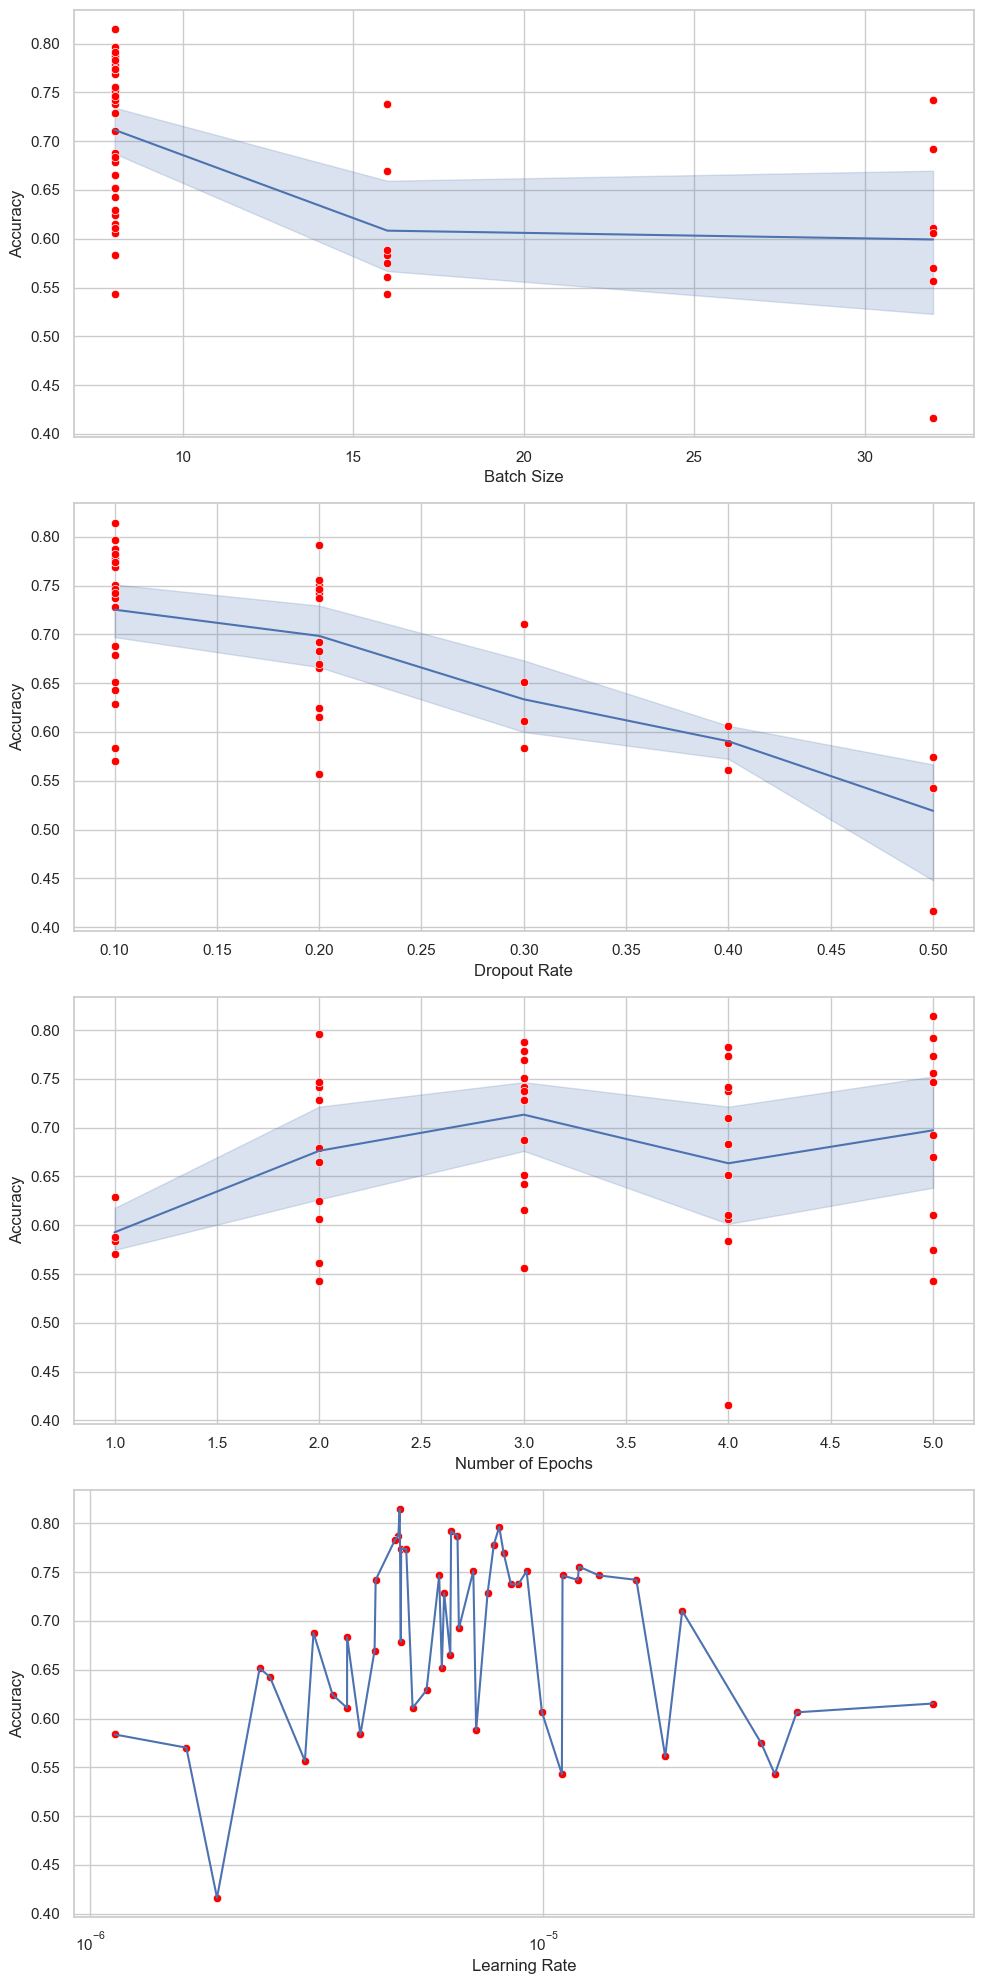

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style
sns.set_style("whitegrid")

# Plotting scatter and line plots for each hyperparameter
fig, axs = plt.subplots(4, 1, figsize=(10, 20))

# Batch Size
sns.lineplot(data=df_trials, x='Batch Size', y='Accuracy', ax=axs[0])
sns.scatterplot(data=df_trials, x='Batch Size', y='Accuracy', ax=axs[0], color='red')

# Dropout Rate
sns.lineplot(data=df_trials, x='Dropout Rate', y='Accuracy', ax=axs[1])
sns.scatterplot(data=df_trials, x='Dropout Rate', y='Accuracy', ax=axs[1], color='red')

# Number of Epochs
sns.lineplot(data=df_trials, x='Number of Epochs', y='Accuracy', ax=axs[2])
sns.scatterplot(data=df_trials, x='Number of Epochs', y='Accuracy', ax=axs[2], color='red')

# Learning Rate
sns.lineplot(data=df_trials, x='Learning Rate', y='Accuracy', ax=axs[3])
sns.scatterplot(data=df_trials, x='Learning Rate', y='Accuracy', ax=axs[3], color='red')

# Setting log scale for learning rate for better visualization
axs[3].set_xscale('log')

plt.tight_layout()
plt.show()


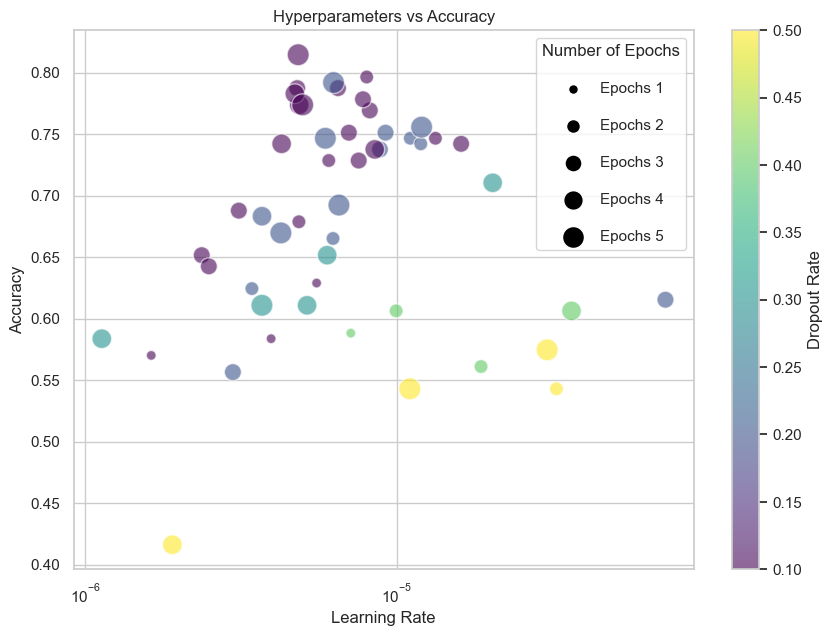

In [40]:
import matplotlib.pyplot as plt

# Define the hyperparameter for the x-axis
x = df_trials['Learning Rate']

# Define the "Accuracy" on the y-axis
y = df_trials['Accuracy']

# Use "Number of Epochs" for the size of the dots, scaled so they're visible
size = df_trials['Number of Epochs'] * 50

# Use "Dropout Rate" for the color of the dots
color = df_trials['Dropout Rate']

# Create scatter plot
plt.figure(figsize=(10, 7))
sc = plt.scatter(x, y, c=color, s=size, cmap='viridis', alpha=0.6, edgecolors='w')
plt.colorbar(sc, label='Dropout Rate')
plt.xscale('log')  # Set x-axis to log scale for better visualization
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Hyperparameters vs Accuracy')

# Add a legend for the sizes (epochs)
for epoch in sorted(df_trials['Number of Epochs'].unique()):
    plt.scatter([], [], s=epoch*50, label=f'Epochs {epoch}', c='black', edgecolors='w')
plt.legend(scatterpoints=1, labelspacing=1.5, title='Number of Epochs')

plt.show()


In [46]:
# Convert the duration column from timedelta64[ns] to float (seconds)
df_trials['duration_seconds'] = df_trials['duration'].dt.total_seconds()
# df = df_trials.drop(columns=['datetime_start', 'datetime_complete', 'duration', 'state'])
# df.to_clipboard()


In [49]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
from torch.nn.functional import softmax

# Assuming df already exists
# If reading from a file:
# df = pd.read_csv('your_file.csv')

# Tokenize the texts
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_length = 256

def tokenize_data(texts, tokenizer, max_length):
    return tokenizer(texts, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')

tokens = tokenize_data(df['text'].tolist(), tokenizer, max_length)

# Create a DataLoader
dataset = TensorDataset(tokens.input_ids, tokens.attention_mask, torch.tensor(df['is_hate'].values).long())
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=8)  # Modified batch_size
val_loader = DataLoader(val_dataset, batch_size=8)  # Modified batch_size

# Initialize the model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
model.config.hidden_dropout_prob = 0.1  # Modified dropout

# Training setup
optimizer = AdamW(model.parameters(), lr=4.825718084617628e-06)  # Modified lr
epochs = 5  # Modified epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.11387251464281245 * len(train_loader)), num_training_steps=len(train_loader) * epochs)  # Modified num_warmup_steps

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):  
        input_ids, attention_mask, labels = batch
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()

    print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss/len(train_loader)}")

# Validation
model.eval()
all_preds = []
all_labels = []
all_probs = []

for batch in tqdm(val_loader, desc="Validation"):  
    input_ids, attention_mask, labels = batch
    with torch.no_grad():
        logits = model(input_ids, attention_mask=attention_mask).logits
    probabilities = softmax(logits, dim=1)
    all_probs.extend(probabilities[:, 1].numpy())
    preds = torch.argmax(logits, dim=1).tolist()
    all_preds.extend(preds)
    all_labels.extend(labels.tolist())

print("Validation Accuracy:", accuracy_score(all_labels, all_preds))
report = classification_report(all_labels, all_preds)
print(report)

# Prediction function
def predict(text, model, tokenizer):
    model.eval()
    tokens = tokenize_data([text], tokenizer, max_length)
    with torch.no_grad():
        logits = model(tokens['input_ids'], attention_mask=tokens['attention_mask']).logits
    return torch.argmax(logits, dim=1).item()

# Sample prediction
text = "Your sample text here"
result = predict(text, model, tokenizer)
print("Hateful" if result == 1 else "Not hateful")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/meuru/projects/MSc/Final Project/venv/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 248/248 [06:58<00:00,  1.69s/it]


Epoch 1/5 | Loss: 0.6825525328036277


Epoch 2: 100%|██████████| 248/248 [06:54<00:00,  1.67s/it]


Epoch 2/5 | Loss: 0.6271817943742198


Epoch 3: 100%|██████████| 248/248 [06:54<00:00,  1.67s/it]


Epoch 3/5 | Loss: 0.5491901341705553


Epoch 4: 100%|██████████| 248/248 [06:56<00:00,  1.68s/it]


Epoch 4/5 | Loss: 0.47454223265090295


Epoch 5: 100%|██████████| 248/248 [06:56<00:00,  1.68s/it]


Epoch 5/5 | Loss: 0.43275580501123784


Validation: 100%|██████████| 28/28 [00:11<00:00,  2.36it/s]

Validation Accuracy: 0.7420814479638009
              precision    recall  f1-score   support

           0       0.75      0.82      0.78       126
           1       0.73      0.64      0.68        95

    accuracy                           0.74       221
   macro avg       0.74      0.73      0.73       221
weighted avg       0.74      0.74      0.74       221

Not hateful


It took 43 mins

In [4]:
# Sample prediction
text = "kalakanni deshapaluwo"
result = predict(text, model, tokenizer)
print("Hateful" if result == 1 else "Not hateful")

Hateful


In [7]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import pickle
import numpy as np

report = classification_report(all_labels, all_preds, target_names=['True', 'False'])
# values for confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # normalize the confusion matrix

# values for ROC curve
# Convert model output to probabilities and plot ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# save the values to a file
with open('2.11 Bert.pkl', 'wb') as f:
    pickle.dump({
        'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc, 'cm_percentage': cm_percentage, 'report': report
    }, f)